In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df_all_device  = pd.read_excel("./Experimental Data/All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
print(df_all_device.columns)
df_all_device = df_all_device.iloc[:,2:12]
df_all_device = df_all_device.dropna()
df_all_device

Index(['ML Condition', 'Sample', 'Temperature [°C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]',
       'Plasma DC [%]', 'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]',
       'Film Success or not?', 'Unnamed: 13', ' ', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137
1,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982
2,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485
3,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839
4,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590
...,...,...,...,...,...,...,...,...,...,...
139,170,300,2500,1.0,25,100,15.171420,0.721700,0.39,4.270196
140,160,100,4000,1.0,25,75,15.428570,0.951900,0.49,7.196364
141,155,275,2500,1.2,35,100,5.652380,0.643600,0.43,1.564446
142,140,225,3000,1.0,20,50,21.495230,0.917800,0.72,14.204410


In [21]:
df_all_device.columns = ['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [mL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X=df_all_device.iloc[:,:6]
y=df_all_device['Efficiency [%]']

X=X.to_numpy(dtype='float')
y=y.to_numpy(dtype='float').reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)
y = scaler_y.transform(y)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(10,200,10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(2,20,2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# learning_rate 
learning_rate = np.arange(0.025,0.150,0.025)
# subsample 
subsample = np.arange(0.60, 0.95, 0.05) 
# 'reg_alpha':        
alpha = [1e-4, 1e-2, 0.1, 0.5, 0.99]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample,
               'alpha': alpha}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, 
                               n_iter = 1000, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)
best_params = gb_random.best_params_


In [23]:
#print(gb_random.best_params_)
best_params = {'subsample': 0.95, 
               'n_estimators': 105, 
               'min_samples_split': 2, 
               'min_samples_leaf': 2, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.075,
               'alpha':0.99
               }

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
GBregressor_list = []
y_pred_list = []
y_train_pred_list = []
y_test_pred_list = []
for i in np.arange(100):
    GBregressor = GradientBoostingRegressor()
    GBregressor.set_params(**best_params)
    #GBregressor.fit(X_train, y_train.ravel())
    GBregressor.fit(X, y.ravel())

    GBregressor_list.append(GBregressor)
    
    y_train_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_train).reshape(-1,1))
    y_test_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_test).reshape(-1,1))
    y_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X).reshape(-1,1))
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_pred_list.append(y_pred)
y_pred_mean = np.mean(y_pred_list, axis = 0)
y_train_pred_mean = np.mean(y_train_pred_list, axis = 0)
y_test_pred_mean = np.mean(y_test_pred_list, axis = 0)


train rmse: 1.0701
test rmse: 0.9287
all rmse: 1.0430
train R^2: 0.9322
test R^2: 0.9666
all R^2: 0.9424
train spearman: 0.9298
test spearman: 0.9148
all spearman: 0.9295


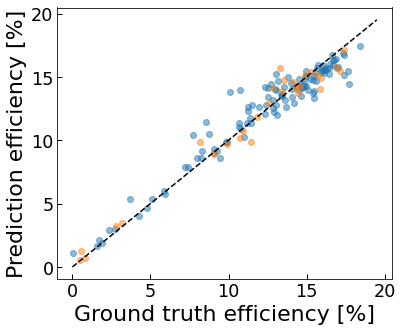

In [25]:
y_train_pred = y_train_pred_mean
y_test_pred = y_test_pred_mean
y_pred = y_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(y_train_pred,scaler_y.inverse_transform(y_train))
mse_test = mse(y_test_pred,scaler_y.inverse_transform(y_test))
mse_all = mse(y_pred,scaler_y.inverse_transform(y))
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(scaler_y.inverse_transform(y_train),y_train_pred)
rsquared_test = r2_score(scaler_y.inverse_transform(y_test), y_test_pred)
rsquared_all = r2_score(scaler_y.inverse_transform(y), y_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(y_train_pred,scaler_y.inverse_transform(y_train))
sprman_test = spearmanr(y_test_pred,scaler_y.inverse_transform(y_test))
sprman_all = spearmanr(y_pred,scaler_y.inverse_transform(y))
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(scaler_y.inverse_transform(y_train),y_train_pred, alpha =0.5)
plt.scatter(scaler_y.inverse_transform(y_test),y_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
yref = np.arange(0, 20, 0.5)
plt.plot(yref, yref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 5, 10, 15, 20])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

In [26]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']

In [27]:
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [28]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
                                 ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
                                 ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
                                 ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
                                 ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
                                 ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
                                 ])


parameter_space = ParameterSpace([ContinuousParameter('temp', 0,1),
                                 ContinuousParameter('speed', 0,1),
                                 ContinuousParameter('sprayFL', 0,1),
                                 ContinuousParameter('plamsaH', 0,1),
                                 ContinuousParameter('gasFL', 0,1),
                                 ContinuousParameter('plasmaDC', 0,1)
                                 ])

In [29]:
df_thiswork  = pd.read_excel("./Experimental Data/All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
df_thiswork = df_thiswork.iloc[:99,0:13]
thiswork_device = df_thiswork['Film Success or not?'] == 'Yes'

In [30]:
y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(X[:99][thiswork_device])
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)

y_pred_thiswork_device = scaler_y.inverse_transform(y_hat_mean)
df_thiswork_device = df_thiswork.iloc[:99,2:8][thiswork_device].copy()
df_thiswork_device = df_thiswork_device.dropna()

max(y_pred_thiswork_device)
df_thiswork_device['Efficiency [%]'] = np.around(y_pred_thiswork_device,2)
df_thiswork_device.iloc[np.argmax(y_pred_thiswork_device):np.argmax(y_pred_thiswork_device)+1]
df_thiswork_device[df_thiswork_device['Efficiency [%]']>16]


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
70,140,200,4000,0.80,20,50,16.71
79,144,166,3270,1.15,19,44,17.10
82,149,170,3160,1.00,20,35,16.43
85,149,148,3120,1.00,18,37,16.91
89,141,134,3050,1.20,20,48,16.37
91,141,174,3010,1.00,16,42,16.36
95,140,150,3500,1.00,20,50,16.71


the rate of top 1 perc (>15%): 0.34


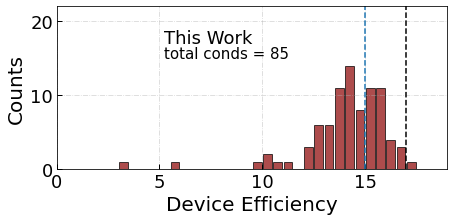

In [31]:
print("the rate of top 1 perc (>15%):", np.around (np.sum(df_thiswork_device.iloc[:,-1]>=15.04)/85, 2))
fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
axes.hist(df_thiswork_device.iloc[:,-1], bins= 40, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####
axes.text(5.2, 17, 'This Work', fontsize=fs*0.9)
axes.text(5.2, 15, 'total conds = '+str(len(df_thiswork_device)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, 22)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, 22, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, 22, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [32]:
x_grid = []
for x1 in np.linspace(0, 1, temp_num):#int((temp_num-1)/2+1)): 
    for x2 in np.linspace(0, 1, speed_num):
        for x3 in np.linspace(0, 1, sprayFL_num):
            for x4 in np.linspace(0, 1, plasmaH_num):
                for x5 in np.linspace(0, 1, gasFL_num):
                    for x6 in np.linspace(0, 1, plasmaDC_num):
                        x_grid.append([x1,x2,x3,x4,x5,x6])

x_grid_original = x_denormalizer(x_grid)
df_fullgrid = pd.DataFrame(x_grid_original, columns = x_labels)
df_fullgrid

y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_grid_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)


y_pred_grid = scaler_y.inverse_transform(y_hat_mean)
max(y_pred_grid)
df_fullgrid['Efficiency [%]'] = np.around(y_pred_grid, 2)
df_fullgrid.iloc[np.argmax(y_pred_grid):np.argmax(y_pred_grid)+1]

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
15700,145.0,125.0,3000.0,1.2,15.0,25.0,17.09


max:  17.09
min:  -3.16
top 1 perc:  15.28
top 0.1 perc:  16.15
mean efficiency:  8.87
median efficiency:  9.32


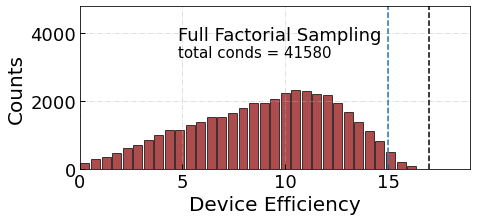

In [42]:
print('max: ', np.max(df_fullgrid.iloc[:,-1].values))
print('min: ', np.min(df_fullgrid.iloc[:,-1].values))

print('top 1 perc: ', np.quantile(df_fullgrid.iloc[:,-1].values, 0.99))
print('top 0.1 perc: ', np.quantile(df_fullgrid.iloc[:,-1].values, 0.999))

print('mean efficiency: ', np.around(np.mean(df_fullgrid.iloc[:,-1].values),2))
print('median efficiency: ', np.median(df_fullgrid.iloc[:,-1].values))


fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_fullgrid.iloc[:,-1], bins= 40, range = (0, 20.5), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####
axes.text(4.8, 3800, 'Full Factorial Sampling', fontsize=fs*0.9)
axes.text(4.8, 3300, 'total conds = '+str(len(df_fullgrid)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, 4800)
#axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, 5000, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, 5000, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

In [47]:
np.random.seed(10)
design = RandomDesign(parameter_space)
x_random = design.get_samples(100000)
#x_random_original = get_closest_array(x_denormalizer(x_random))
x_random_original = x_denormalizer(x_random)
df_random = pd.DataFrame(x_random_original, columns = x_labels)
df_random
y_hat_list = []
for i in np.arange(len(GBregressor_list)):
    y_hat = GBregressor_list[i].predict(scaler.transform(x_random_original))
    y_hat_list.append(y_hat)
y_hat_mean = np.mean(y_hat_list, axis = 0)

y_pred_random = scaler_y.inverse_transform(y_hat_mean)
max(y_pred_random)

df_random['Efficiency [%]'] = np.around(y_pred_random, 2)
df_random.iloc[np.argmax(y_pred_random):np.argmax(y_pred_random)+1]

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Efficiency [%]
31422,142.163437,183.535418,3415.702199,1.056887,15.395033,30.106381,17.61


max:  17.35
min:  -2.95
top 5 perc:  0.7967157417893544
top 1 perc:  0.8533408833522084
top 0.1 perc:  0.9043035107587769
mean efficiency:  9.354036200000001


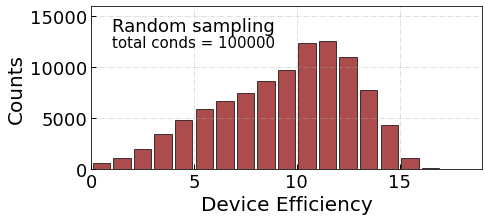

In [88]:
print('max: ', np.max(df_random.iloc[:,-1].values))
print('min: ', np.min(df_random.iloc[:,-1].values))
print('top 5 perc: ', np.quantile(df_random.iloc[:,-1].values, 0.95)/17.66)
print('top 1 perc: ', np.quantile(df_random.iloc[:,-1].values, 0.99)/17.66)
print('top 0.1 perc: ', np.quantile(df_random.iloc[:,-1].values, 0.999)/17.66)

print('mean efficiency: ', np.mean(df_random.iloc[:,-1].values))


fs = 20
fig,axes = plt.subplots(1, 1, figsize=(7, 3), sharex = True)
hist_data = axes.hist(df_random.iloc[:,-1], bins= 20, range = (0, 20), 
             rwidth = 0.85, color = 'darkred', alpha = 0.7,
             edgecolor='k')####
axes.text(1, 6800*2, 'Random sampling', fontsize=fs*0.9)
axes.text(1, 6000*2, 'total conds = '+str(len(df_random)), fontsize=15)
axes.tick_params(direction='in', length=5, width=1, labelsize = fs*.9, grid_alpha = 0.5)
axes.grid(True, linestyle='-.')
axes.set_ylabel('Counts', fontsize = fs)
axes.set_xlim(0, 19)
axes.set_ylim(0, 8000*2)
##axes.set_yticks([0, 4, 8, 12])
axes.plot(np.ones(10)*15, np.linspace(0, 20, 10), '--')
axes.plot(np.ones(10)*17, np.linspace(0, 20, 10), '--', color = 'black')
axes.set_xlabel('Device Efficiency', fontsize = fs)

plt.show()

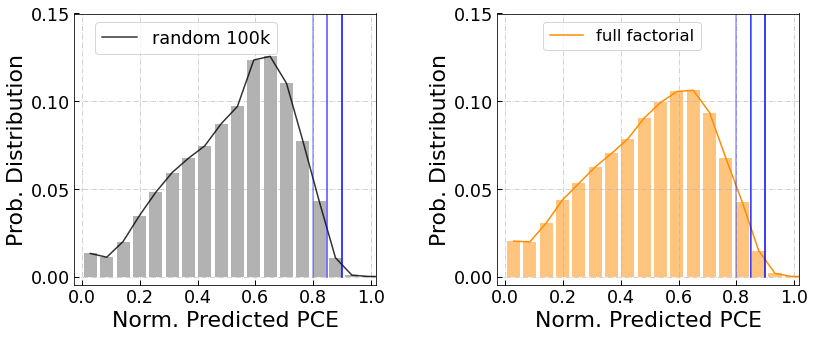

In [90]:
norm_factor = 17.66

hist_data = np.histogram(df_random.iloc[:,-1], bins=np.arange(21))
random100k_norm_eff = (hist_data[1][1:]- 1/2)/norm_factor
random100k_distr = hist_data[0]/len(df_random)
random100k_cum = np.cumsum(random100k_distr) 
corr_for_neg_eff = 1-random100k_cum[-1]
random100k_distr[0] = random100k_distr[0] + corr_for_neg_eff
random100k_cum = np.cumsum(random100k_distr) 
random100k_distr[0] = random100k_distr[0] + corr_for_neg_eff

hist_data = np.histogram(df_fullgrid.iloc[:,-1], bins=np.arange(21))
fullgrid_norm_eff =(hist_data[1][1:]- 1/2)/norm_factor
fullgrid_distr = hist_data[0]/len(df_fullgrid)
fullgrid_cum = np.cumsum(fullgrid_distr) 
corr_for_neg_eff = 1-fullgrid_cum[-1]
fullgrid_distr[0] = fullgrid_distr[0] + corr_for_neg_eff
fullgrid_cum = np.cumsum(fullgrid_distr) 



fig,axes = plt.subplots(1, 2, figsize=(13, 5), sharex = True)
fs = 22
ax = axes[0]
ax.plot(random100k_norm_eff, random100k_distr, color = 'black', linewidth = 1.5, alpha = 0.8, label = 'random 100k') 
ax.bar(random100k_norm_eff, random100k_distr, color = 'black', width = 0.8/norm_factor, linewidth = 1.5, alpha = 0.3) 

ax.plot(np.ones(100)*0.8, np.linspace(0, 2,100), color = 'blue', alpha = 0.4, linewidth = 1.5) 
ax.plot(np.ones(100)*0.85, np.linspace(0, 2,100), color = 'blue', alpha = 0.7, linewidth =  1.5) 
ax.plot(np.ones(100)*0.90, np.linspace(0, 2,100), color = 'blue', alpha = 1, linewidth =  1.5) 

ax.set_ylabel('Prob. distr.', fontsize = fs)
ax.set_ylim(-0.005, 0.15)
ax.set_yticks([0, 0.05, 0.1, 0.15])
#ax.set_xlim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(0.2,0.1, 0.5, 0.9), fontsize = fs*0.8)
if norm_factor == 1:
    ax.set_xlabel('Predicted efficiency [%]', fontsize = fs)
else:
    ax.set_xlabel('Norm. predicted efficiency', fontsize = fs)

    
ax = axes[1]
ax.plot(fullgrid_norm_eff, fullgrid_distr, color = 'darkorange', linewidth = 1.5, alpha = 1, label = 'full factorial') 
ax.bar(fullgrid_norm_eff, fullgrid_distr, color = 'darkorange', width=0.8/norm_factor, linewidth = 1.5, alpha = 0.5) 
ax.plot(np.ones(100)*15/norm_factor, np.linspace(0, 2,100), color = 'blue', alpha = 0.6, linewidth = 0.8) 
#ax.plot(np.ones(100)*16.8/norm_factor, np.linspace(0, 2,100), color = 'black', alpha = 0.7, linewidth = 0.8) 
ax.plot(np.ones(100)*0.8, np.linspace(0, 2,100), color = 'blue', alpha = 0.4, linewidth = 1.5) 
ax.plot(np.ones(100)*0.85, np.linspace(0, 2,100), color = 'blue', alpha = 0.7, linewidth =  1.5) 
ax.plot(np.ones(100)*0.90, np.linspace(0, 2,100), color = 'blue', alpha = 1, linewidth =  1.5) 


ax.set_ylabel('Prob. distr.', fontsize = fs)
if norm_factor == 1:
    ax.set_xlabel('Predicted efficiency [%]', fontsize = fs)
else:
    ax.set_xlabel('Norm. predicted efficiency', fontsize = fs)

ax.set_ylim(-0.005, 0.15)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_xlim(-.5/norm_factor, 18/norm_factor)


ax.legend(bbox_to_anchor=(0.2,0.1, 0.5, 0.9), fontsize = fs*0.75)

for ax in axes:
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    ax.set_ylabel('Prob. Distribution', fontsize = fs)
    if norm_factor == 1:
        ax.set_xlabel('Predicted PCE [%]', fontsize = fs)
    else:
        ax.set_xlabel('Norm. Predicted PCE', fontsize = fs)

    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.7)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)
plt.show()

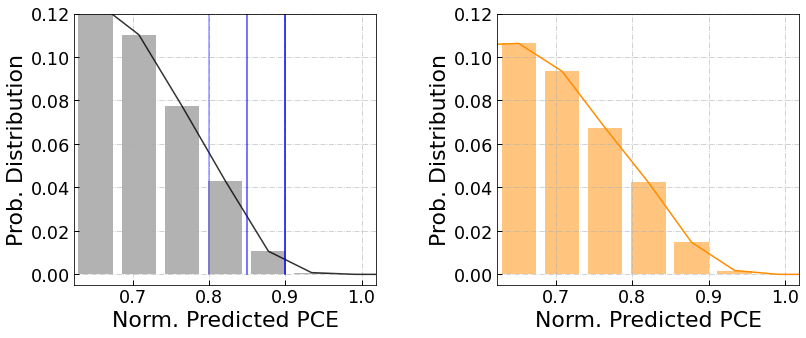

In [91]:
norm_factor = 17.66

hist_data = np.histogram(df_random.iloc[:,-1], bins=np.arange(21))
random100k_norm_eff = (hist_data[1][1:]- 1/2)/norm_factor
random100k_distr = hist_data[0]/len(df_random)
random100k_cum = np.cumsum(random100k_distr) 
corr_for_neg_eff = 1-random100k_cum[-1]
random100k_distr[0] = random100k_distr[0] + corr_for_neg_eff
random100k_cum = np.cumsum(random100k_distr) 
random100k_distr[0] = random100k_distr[0] + corr_for_neg_eff

hist_data = np.histogram(df_fullgrid.iloc[:,-1], bins=np.arange(21))
fullgrid_norm_eff =(hist_data[1][1:]- 1/2)/norm_factor
fullgrid_distr = hist_data[0]/len(df_fullgrid)
fullgrid_cum = np.cumsum(fullgrid_distr) 
corr_for_neg_eff = 1-fullgrid_cum[-1]
fullgrid_distr[0] = fullgrid_distr[0] + corr_for_neg_eff
fullgrid_cum = np.cumsum(fullgrid_distr) 



fig,axes = plt.subplots(1, 2, figsize=(13, 5), sharex = True)
fs = 22
ax = axes[0]
ax.plot(random100k_norm_eff, random100k_distr, color = 'black', linewidth = 1.5, alpha = 0.8, label = 'random 100k') 
ax.bar(random100k_norm_eff, random100k_distr, color = 'black', width = 0.8/norm_factor, linewidth = 1.5, alpha = 0.3) 

ax.plot(np.ones(100)*0.8, np.linspace(0, 2,100), color = 'blue', alpha = 0.4, linewidth = 1.5) 
ax.plot(np.ones(100)*0.85, np.linspace(0, 2,100), color = 'blue', alpha = 0.7, linewidth =  1.5) 
ax.plot(np.ones(100)*0.90, np.linspace(0, 2,100), color = 'blue', alpha = 1, linewidth =  1.5) 


ax.set_ylabel('Prob. distr.', fontsize = fs)
#ax.set_xlim(-0.02, 1.02)
#ax.legend(bbox_to_anchor=(0.2,0.1, 0.5, 0.9), fontsize = fs*0.8)



ax = axes[1]
ax.plot(fullgrid_norm_eff, fullgrid_distr, color = 'darkorange', linewidth = 1.5, alpha = 1, label = 'full factorial') 
ax.bar(fullgrid_norm_eff, fullgrid_distr, color = 'darkorange', width=0.8/norm_factor, linewidth = 1.5, alpha = 0.5) 


#ax.plot(np.ones(100)*16.8/norm_factor, np.linspace(0, 2,100), color = 'black', alpha = 0.7, linewidth = 0.8) 





#ax.legend(bbox_to_anchor=(0.2,0.1, 0.5, 0.9), fontsize = fs*0.75)

for ax in axes:
    ax.set_xlim(11/norm_factor, 18/norm_factor)

    ax.set_ylabel('Prob. Distribution', fontsize = fs)
    if norm_factor == 1:
        ax.set_xlabel('Predicted PCE [%]', fontsize = fs)
    else:
        ax.set_xlabel('Norm. Predicted PCE', fontsize = fs)

    ax.set_ylim(-0.005, 0.12)
    ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.7)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)
plt.show()